# **SECTION_02 PROJECT**

## 1. 데이터 선정 이유 및 문제 정의

세계적으로 사망률이 가장 높은 질병이 어떤 질병인지 아시나요?

바로 Heart disease, 심장병입니다.

따라서, 저는 심장병을 미리 예방하기 위한 분류모델을 구축해보려고 합니다.

데이터 출처 : https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [282]:
# import libraries
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import  accuracy_score, roc_auc_score
from sklearn.metrics import  classification_report, plot_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from category_encoders import OrdinalEncoder

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [2]:
raw_data = pd.read_csv('./data/heart.csv')

print(raw_data.shape)
print('---')

raw_data.head(3)

(918, 12)
---


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0

In [3]:
# 프로파일링 결과 리포트를 pr에 저장
pr=raw_data.profile_report()

# pr_report.html 파일로 저장
pr.to_file('./pr_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 49.66it/s]


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# 중복값 제거
raw_data.drop_duplicates(inplace=True)
raw_data.shape

(918, 12)

In [6]:
raw_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

[Text(1, 0.5, 'Cholesterol'),
 Text(1, 1.5, 'MaxHR'),
 Text(1, 2.5, 'RestingBP'),
 Text(1, 3.5, 'FastingBS'),
 Text(1, 4.5, 'Age'),
 Text(1, 5.5, 'Oldpeak'),
 Text(1, 6.5, 'HeartDisease')]

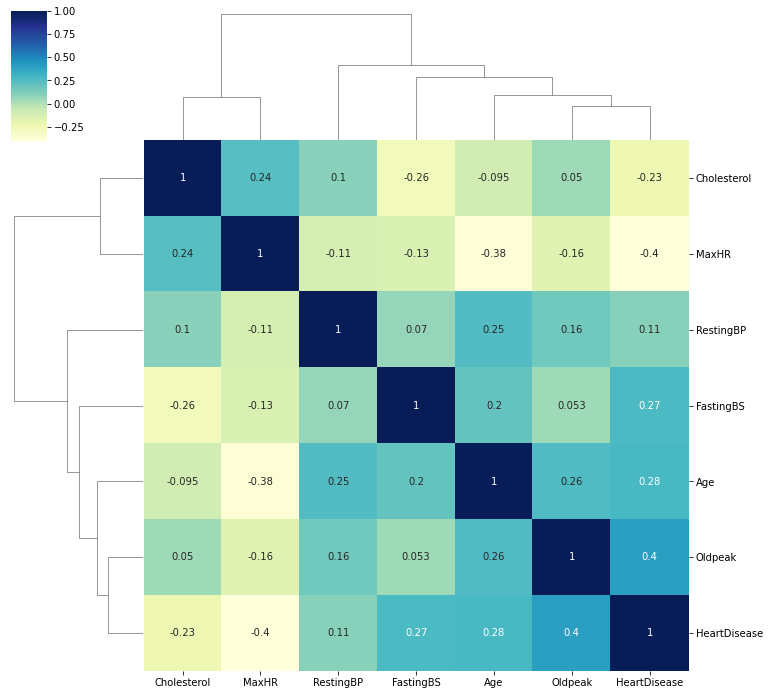

In [7]:
raw_data_corr = raw_data.corr()

plot_corr = sns.clustermap(data = raw_data_corr,
                           metric="correlation",
                           annot=True,
                           cmap="YlGnBu"
                           )

plot_corr.ax_heatmap.set_yticklabels(plot_corr.ax_heatmap.get_yticklabels(),
                                     rotation=0)

'Heartdisease'와 'cholesterol', 'MaxHR'이 음수인걸 볼 수 있다.

In [8]:
# HeartDisease 비율
fig = px.histogram(raw_data,
                   x='HeartDisease',
                   color='HeartDisease'
                   )

fig.update_layout(barmode="overlay",
                  bargap=0.1
                  )
fig.show()

In [9]:
# 남여 비율
fig = px.histogram(raw_data,
                   x='Sex',
                   color='Sex',
                   )
fig.show()

In [10]:
# 남여 심장병 비율
fig = px.histogram(raw_data,
                   x='HeartDisease',
                   color='Sex',
                   barmode='group',
                   hover_data=raw_data.columns
                   )
fig.show()

In [11]:
# 연령별 심장병 비율
Age_data = pd.DataFrame(raw_data['HeartDisease'].groupby(raw_data['Age']).count()).reset_index()
fig = px.bar(Age_data,
             x='Age',
             y='HeartDisease'
             )
fig.show()

In [12]:
fig=px.histogram(raw_data,
                 x="ChestPainType",
                 color="ChestPainType"
                )
fig.show()

In [13]:
fig=px.histogram(raw_data,
                 x="RestingECG",
                 color="RestingECG"
                )
fig.show()

In [14]:
# ExerciseAngina
fig=px.histogram(raw_data,
                 x="ExerciseAngina",
                 color="ExerciseAngina"
                )
fig.show()

In [15]:
# ST_Slope
fig=px.histogram(raw_data,
                 x="ST_Slope",
                 color="ST_Slope"
                )
fig.show()

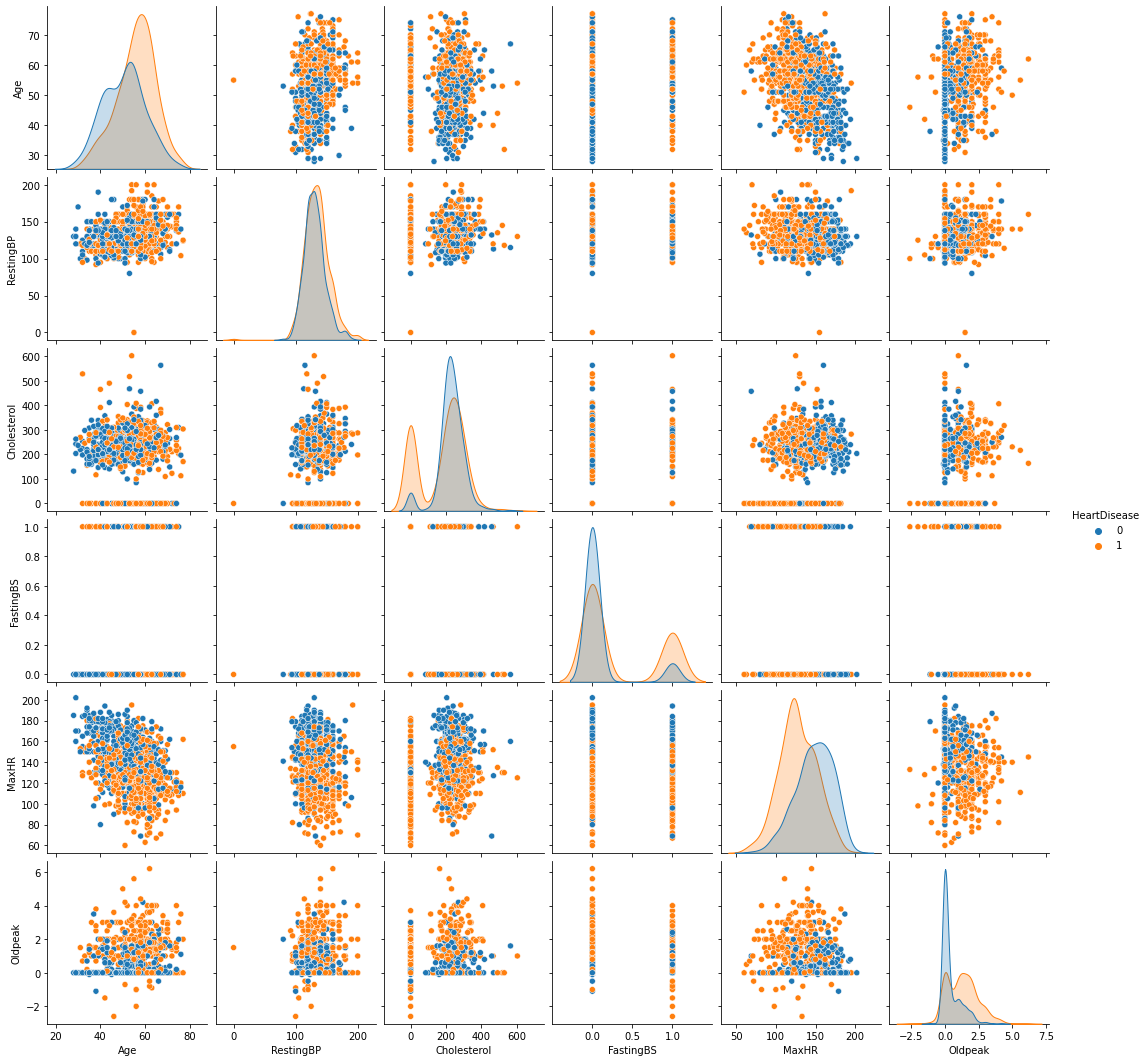

In [16]:
sns.pairplot(raw_data, diag_kind='kde', hue="HeartDisease")

In [17]:
fig = px.box(raw_data,
             x="HeartDisease",
             y="Age"
             )
fig.show()

In [18]:
fig = px.box(raw_data,
             x="HeartDisease",
             y="RestingBP",
             color='Sex'
             )
fig.show()

In [19]:
fig = px.box(raw_data,
             x="HeartDisease",
             y="Cholesterol",
             )
fig.show()

In [20]:
fig = px.box(raw_data,
             x="HeartDisease",
             y="Oldpeak",
             )
fig.show()

In [21]:
fig = px.box(raw_data,
             x="HeartDisease",
             y="MaxHR",
             )
fig.show()

## 2. Data Preprocessing

In [22]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 133.2+ KB


In [23]:
raw_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [24]:
# categorical columns
str_col = raw_data.select_dtypes(include="object").columns
raw_data[str_col] = raw_data[str_col].astype("string")
str_col = raw_data.select_dtypes("string").columns.to_list()
str_col


['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [25]:
# numerical columns
num_col = raw_data.select_dtypes("int64").columns.to_list()
num_col = num_col + raw_data.select_dtypes("float64").columns.to_list()
num_col.remove("HeartDisease")
num_col

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Target = HeartDisease

In [26]:
target = "HeartDisease"

1. Non-tree Model

In [27]:
# one-hot encoding 적용
logistic_data = pd.get_dummies(raw_data, columns=str_col)
logistic_data.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0      0      1                  0  ...                  0                 0   
1      1      0                  0  ...                  1                 0   
2      0      1                  0  ...                  0                 0   
3      1      0                  1  ...                  0                 0   
4      0      1                  0  ...                  1                 0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0               0                  1              0                 1   
1               0                  1              0                 1   
2               0                  0              1                 1   
3               0                  1              0                 0   
4               0                  1              0                 1   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0                 0              0              0            1  
1                 0              0              1            0  
2                 0              0              0            1  
3                 1              0              1            0  
4                 0              0              0            1  

[5 rows x 21 columns]

In [28]:
logistic_train_all, logistic_test = train_test_split(logistic_data, test_size=0.2, random_state=2)
logistic_train, logistic_val = train_test_split(logistic_train_all, test_size=0.2, random_state=2)

# train_all
logistic_X_train_all = logistic_train_all.drop(target, axis=1)
logistic_y_train_all = logistic_train_all[target]

# train
logistic_X_train = logistic_train.drop(target, axis=1)
logistic_y_train = logistic_train[target]

# val
logistic_X_val = logistic_val.drop(target, axis=1)
logistic_y_val = logistic_val[target]

# test
logistic_X_test = logistic_test.drop(target, axis=1)
logistic_y_test = logistic_test[target]

2. Tree Model

In [29]:
ordinal_cols_mapping = [{
    "col":"Sex",
    "mapping": {
        'M':1,
        'F':0
    }}, {
    "col":"ChestPainType",
    "mapping":{
        'ASY':0,
        'ATA':1,
        'NAP':2,
        'TA':3
    }}, {
    "col":"RestingECG",
    "mapping":{
        'LVH':0,
        'Normal':1,
        'ST':2
    }}, {
    "col":"ExerciseAngina",
    "mapping":{
        'N':0,
        'Y':1
    }}, {
    "col":"ST_Slope",
    "mapping":{
        'Down':0,
        'Flat':1,
        'Up':2
    }}
]

In [30]:
ord_enc = OrdinalEncoder(cols = str_col,
                         mapping = ordinal_cols_mapping,
                         return_df = True)
ord_enc.fit(raw_data)

D:\Program Files\anaconda3\envs\project2\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



OrdinalEncoder(cols=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina',
                     'ST_Slope'],
               mapping=[{'col': 'Sex', 'mapping': {'F': 0, 'M': 1}},
                        {'col': 'ChestPainType',
                         'mapping': {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}},
                        {'col': 'RestingECG',
                         'mapping': {'LVH': 0, 'Normal': 1, 'ST': 2}},
                        {'col': 'ExerciseAngina', 'mapping': {'N': 0, 'Y': 1}},
                        {'col': 'ST_Slope',
                         'mapping': {'Down': 0, 'Flat': 1, 'Up': 2}}])

In [31]:
tree_data = ord_enc.fit_transform(raw_data)
tree_data.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122               0      0.0         2             0

In [32]:
tree_train_all, tree_test = train_test_split(tree_data, test_size=0.2, random_state=2)
tree_train, tree_val = train_test_split(tree_train_all, test_size=0.2, random_state=2)
print("tree_train shape: ", tree_train.shape)
print("tree_val shape: ", tree_val.shape)
print("tree_test shape: ", tree_test.shape)

tree_train shape:  (587, 12)
tree_val shape:  (147, 12)
tree_test shape:  (184, 12)


In [33]:
# train_all
tree_X_train_all = tree_train_all.drop(target, axis=1)
tree_y_train_all = tree_train_all[target]

# train
tree_X_train = tree_train.drop(target, axis=1)
tree_y_train = tree_train[target]

# val
tree_X_val = tree_val.drop(target, axis=1)
tree_y_val = tree_val[target]

# test
tree_X_test = tree_test.drop(target, axis=1)
tree_y_test = tree_test[target]

## 3. Model

### 3.1 Baseline Model

In [34]:
base_train, base_test = train_test_split(raw_data, test_size=0.2, random_state=2)
print("base_train shape: ", base_train.shape)
print("base_test shape: ", base_test.shape)

base_train shape:  (734, 12)
base_test shape:  (184, 12)


In [35]:
# 타겟 데이터 범주의 비율을 확인
base_y_train = base_train[target]
base_y_train.value_counts(normalize=True)

1    0.56267
0    0.43733
Name: HeartDisease, dtype: float64

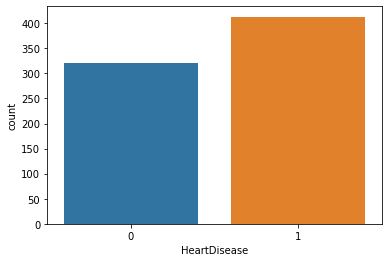

In [36]:
sns.countplot(x = base_y_train);

In [37]:
# mode(): Return the highest frequency value in a Series. 최빈값
major = base_y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만듭니다. 기준모델로 예측
base_y_train_pred = [major] * len(base_y_train)

# 최다 클래스의 빈도가 정확도가 됩니다.
print("training accuracy: ", accuracy_score(base_y_train, base_y_train_pred))

# 검증세트 에서도 정확도를 확인해 볼 수 있습니다.
base_y_test = base_test[target]
base_y_test_pred = [major] * len(base_y_test)
print("---")
print("test")
base_acc = accuracy_score(base_y_test, base_y_test_pred)
base_auc = roc_auc_score(base_y_test, base_y_test_pred)
print('accuracy_score :', base_acc)
print('auc_score :', base_auc)

training accuracy:  0.5626702997275205
---
test
accuracy_score : 0.5163043478260869
auc_score : 0.5


### 3.2 Non-Tree Model

#### 3.2.1 Logistic Regression

1. cross-validation

In [38]:
logistic_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)

logistic_pipe.fit(logistic_X_train, logistic_y_train)
print('훈련 정확도: ', logistic_pipe.score(logistic_X_train, logistic_y_train))
print('검증 정확도: ', logistic_pipe.score(logistic_X_val, logistic_y_val))

훈련 정확도:  0.8603066439522998
검증 정확도:  0.9251700680272109


In [39]:
# cross-validation
logistic_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)

k = 5
logistic_cv_scores = cross_val_score(logistic_model,
                                     logistic_X_train_all,
                                     logistic_y_train_all,
                                     cv=k,
                                     scoring='accuracy'
                                     )

logistic_cv_scores.mean()

0.8638057962911192

In [83]:
# GridSearchCV
param_grid = {
    "penalty" : ["l1", "l2", "elasticnet"],
    "l1_ratio" : np.linspace(0, 1, 20),
    "C" : np.logspace(0, 10, 20)}


log_grid_model = LogisticRegression(solver='saga',
                                    max_iter=5000,
                                    class_weight = "balanced"
                                    )

log_grid_model = GridSearchCV(log_grid_model,
                              param_grid = param_grid,
                              cv=3)

In [84]:
log_grid_model.fit(logistic_X_train_all, logistic_y_train_all)

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

D:\Program Files\anaconda3\envs\project2\lib\site-packages\skle

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, solver='saga'),
             param_grid={'C': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [85]:
print(log_grid_model.best_params_)
print(log_grid_model.best_estimator_)

{'C': 1.0, 'l1_ratio': 0.0, 'penalty': 'l1'}
LogisticRegression(class_weight='balanced', l1_ratio=0.0, max_iter=5000,
                   penalty='l1', solver='saga')


In [304]:
# permutation importances
permuter = PermutationImportance(
    log_grid_model,                  # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(logistic_X_train_all, logistic_y_train_all);

In [305]:
feature_names = logistic_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope_Flat        0.024523
Oldpeak              0.020981
Cholesterol          0.020981
ST_Slope_Up          0.014441
ChestPainType_ASY    0.009809
FastingBS            0.007357
Sex_F                0.004360
ChestPainType_ATA    0.003270
MaxHR                0.002997
Sex_M                0.002725
ExerciseAngina_N     0.001362
RestingECG_ST        0.000545
RestingBP            0.000545
Age                  0.000272
ChestPainType_TA     0.000000
RestingECG_LVH       0.000000
RestingECG_Normal    0.000000
ST_Slope_Down        0.000000
ExerciseAngina_Y    -0.000817
ChestPainType_NAP   -0.001362
dtype: float64

In [168]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [315]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = logistic_X_train_all.columns[mask]
log_X_train_selected = logistic_X_train_all[features]
log_X_test_selected = logistic_X_test[features]

In [316]:
logistic_model = LogisticRegression(class_weight='balanced',
                                    l1_ratio=0.0,
                                    max_iter=5000,
                                    penalty='l1',
                                    solver='saga'
                                    )

logistic_model.fit(log_X_train_selected, logistic_y_train_all);

In [317]:
logistic_y_test_pred = logistic_model.predict(log_X_test_selected)

log_acc = accuracy_score(logistic_y_test, logistic_y_test_pred)
log_auc = roc_auc_score(logistic_y_test, logistic_y_test_pred)
print('accuracy_score :', log_acc)
print('auc_score :', log_auc)
print('---')
print(classification_report(logistic_y_test, logistic_y_test_pred))

accuracy_score : 0.8586956521739131
auc_score : 0.8585452395032525
---
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        89
           1       0.86      0.86      0.86        95

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



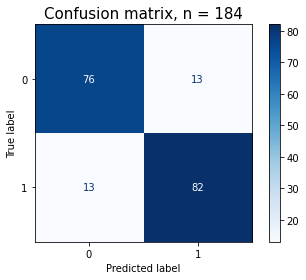

In [197]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(logistic_model,
                            log_X_test_selected,
                            logistic_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(logistic_y_test)), fontsize=15)
plt.show()

### 3.3 Tree Model

#### 3.3.1 Decision Tree

In [96]:
decision_pipe = make_pipeline(
    DecisionTreeClassifier(random_state=2,
                           min_samples_leaf=10,
                           max_depth=6,
                           criterion='entropy'
                           )
)

decision_pipe.fit(tree_X_train, tree_y_train)
print('훈련 정확도: ', decision_pipe.score(tree_X_train, tree_y_train))
print('검증 정확도: ', decision_pipe.score(tree_X_val, tree_y_val))

훈련 정확도:  0.879045996592845
검증 정확도:  0.8231292517006803


In [97]:
# cross-validation
decision_model = DecisionTreeClassifier(random_state=2,
                                        min_samples_leaf=10,
                                        max_depth=6,
                                        criterion='entropy'
                                        )

k = 5
decision_cv_scores = cross_val_score(decision_model,
                                     tree_X_train_all,
                                     tree_y_train_all,
                                     cv=k,
                                     scoring='accuracy'
                                     )

decision_cv_scores.mean()

0.8406299506103811

In [109]:
# GridSearchCV
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 3, 5, 7],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [3, 5, 7]}

DT_grid_model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)

DT_grid_model = GridSearchCV(DT_grid_model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1,
                            verbose = 2
                            )

In [110]:
DT_grid_model.fit(tree_X_train_all, tree_y_train_all)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 7],
                         'max_features': [None, 3, 5, 7],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [3, 5, 7],
                         'splitter': ['best', 'random']},
             scoring='recall', verbose=2)

In [111]:
print(DT_grid_model.best_params_)
print(DT_grid_model.best_estimator_)

{'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 3, 'splitter': 'random'}
DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_features=7,
                       min_samples_leaf=5, min_samples_split=3, random_state=42,
                       splitter='random')


In [198]:
# permutation importances
permuter = PermutationImportance(
    DT_grid_model,                   # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(tree_X_train_all, tree_y_train_all);

In [199]:
feature_names = tree_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope          0.154768
Cholesterol       0.055858
ExerciseAngina    0.039782
Sex               0.022616
ChestPainType     0.017439
Oldpeak           0.000000
MaxHR             0.000000
RestingECG        0.000000
FastingBS         0.000000
RestingBP         0.000000
Age               0.000000
dtype: float64

In [200]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [201]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = tree_X_train_all.columns[mask]
tree_X_train_selected = tree_X_train_all[features]
tree_X_test_selected = tree_X_test[features]

In [202]:
DT_model = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=3,
                                  max_features=5,
                                  min_samples_leaf=5,
                                  min_samples_split=3,
                                  random_state=42,
                                  splitter='random'
                                  )

DT_model.fit(tree_X_train_selected, tree_y_train_all);

In [203]:
decision_y_test_pred = DT_model.predict(tree_X_test_selected)

decision_acc = accuracy_score(tree_y_test, decision_y_test_pred)
decision_auc = roc_auc_score(tree_y_test, decision_y_test_pred)
print('accuracy_score :', decision_acc)
print('auc_score :', decision_auc)
print('---')
print(classification_report(tree_y_test, decision_y_test_pred))

accuracy_score : 0.8260869565217391
auc_score : 0.8244825547013602
---
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        89
           1       0.81      0.87      0.84        95

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



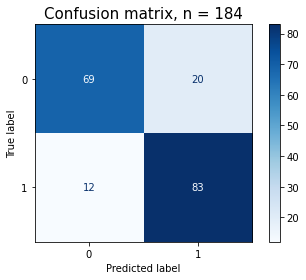

In [205]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(DT_model,
                            tree_X_test_selected,
                            tree_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(tree_y_test)), fontsize=15)
plt.show()

#### 3.3.2 Random Forests

In [113]:
RF_pipe = make_pipeline(
    RandomForestClassifier(n_jobs=-1,
                           random_state=2,
                           min_samples_leaf=10,
                           max_depth=6,
                           oob_score=True
                           )
)

RF_pipe.fit(tree_X_train, tree_y_train)
print('훈련 정확도: ', RF_pipe.score(tree_X_train, tree_y_train))
print('검증 정확도: ', RF_pipe.score(tree_X_val, tree_y_val))

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



훈련 정확도:  0.8858603066439523
검증 정확도:  0.9455782312925171


In [114]:
# cross-validation
RF_model = RandomForestClassifier(n_jobs=-1,
                                  random_state=2,
                                  min_samples_leaf=10,
                                  max_depth=6,
                                  oob_score=True
                                  )

k = 5
RF_cv_scores = cross_val_score(RF_model,
                                     tree_X_train_all,
                                     tree_y_train_all,
                                     cv=k,
                                     scoring='accuracy'
                                     )

RF_cv_scores.mean()

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



0.8719876991892648

In [115]:
# GridSearchCV
param_grid = {'n_estimators':[50, 100],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7],
             'min_samples_split':[2, 5, 8]}

RF_grid_model = RandomForestClassifier(random_state=11)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1,
                             verbose = 2
                             )

In [116]:
RF_grid_model.fit(tree_X_train_all, tree_y_train_all)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=11), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_features': [2, 3, 4],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [50, 100]},
             scoring='recall', verbose=2)

In [117]:
print(RF_grid_model.best_params_)
print(RF_grid_model.best_estimator_)

{'max_depth': 5, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=5, max_features=2, random_state=11)


In [206]:
# permutation importances
permuter = PermutationImportance(
    RF_grid_model,                   # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(tree_X_train_all, tree_y_train_all);

In [207]:
feature_names = tree_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope          0.097275
ChestPainType     0.028065
Cholesterol       0.022343
Oldpeak           0.017984
MaxHR             0.014441
ExerciseAngina    0.011444
Age               0.009537
Sex               0.009264
RestingBP         0.003815
RestingECG        0.001362
FastingBS         0.000817
dtype: float64

In [208]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [225]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = tree_X_train_all.columns[mask]
tree_X_train_selected = tree_X_train_all[features]
tree_X_test_selected = tree_X_test[features]

In [226]:
RF_model = RandomForestClassifier(max_depth=5,
                                  max_features=2,
                                  random_state=11
                                  )

RF_model.fit(tree_X_train_selected, tree_y_train_all);

In [227]:
RF_y_test_pred = RF_model.predict(tree_X_test_selected)

RF_acc = accuracy_score(tree_y_test, RF_y_test_pred)
RF_auc = roc_auc_score(tree_y_test, RF_y_test_pred)
print('accuracy_score :', RF_acc)
print('auc_score :', RF_auc)
print('---')
print(classification_report(tree_y_test, RF_y_test_pred))

accuracy_score : 0.8478260869565217
auc_score : 0.8462448255470136
---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        89
           1       0.83      0.89      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



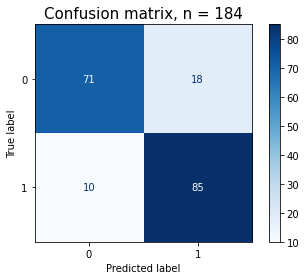

In [228]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(RF_model,
                            tree_X_test_selected,
                            tree_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(tree_y_test)), fontsize=15)
plt.show()

#### 3.3.3 AdaBoostingBoosting

In [120]:
Ada_pipe = make_pipeline(
    AdaBoostClassifier(random_state=2)
)

Ada_pipe.fit(tree_X_train, tree_y_train)
print('훈련 정확도: ', Ada_pipe.score(tree_X_train, tree_y_train))
print('검증 정확도: ', Ada_pipe.score(tree_X_val, tree_y_val))

훈련 정확도:  0.879045996592845
검증 정확도:  0.9183673469387755


In [121]:
# cross-validation
Ada_model = AdaBoostClassifier(random_state=2)

k = 5
Ada_cv_scores = cross_val_score(Ada_model,
                                tree_X_train_all,
                                tree_y_train_all,
                                cv=k,
                                scoring='accuracy'
                                )

Ada_cv_scores.mean()

0.839316000372752

In [124]:
# GridSearchCV
param_grid = {"n_estimators": [15, 20, 50],
              "learning_rate": [0.5, 0.6, 0.7]}

Ada_grid_model = AdaBoostClassifier(random_state=22)
Ada_grid_model = GridSearchCV(Ada_grid_model,
                              param_grid=param_grid,
                              scoring= 'f1'
                              )

In [125]:
Ada_grid_model.fit(tree_X_train_all, tree_y_train_all)

GridSearchCV(estimator=AdaBoostClassifier(random_state=22),
             param_grid={'learning_rate': [0.5, 0.6, 0.7],
                         'n_estimators': [15, 20, 50]},
             scoring='f1')

In [126]:
print(Ada_grid_model.best_params_)
print(Ada_grid_model.best_estimator_)

{'learning_rate': 0.6, 'n_estimators': 20}
AdaBoostClassifier(learning_rate=0.6, n_estimators=20, random_state=22)


In [229]:
# permutation importances
permuter = PermutationImportance(
    Ada_grid_model,                   # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(tree_X_train_all, tree_y_train_all);

In [230]:
feature_names = tree_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope          0.108719
ChestPainType     0.028883
Oldpeak           0.019074
Cholesterol       0.018256
MaxHR             0.012807
RestingBP         0.007902
ExerciseAngina    0.007357
Sex               0.007084
FastingBS         0.003270
Age               0.001635
RestingECG        0.000000
dtype: float64

In [231]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [232]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = tree_X_train_all.columns[mask]
tree_X_train_selected = tree_X_train_all[features]
tree_X_test_selected = tree_X_test[features]

In [233]:
Ada_model = AdaBoostClassifier(learning_rate=0.6,
                               n_estimators=20,
                               random_state=22
                               )

Ada_model.fit(tree_X_train_selected, tree_y_train_all);

In [234]:
Ada_y_test_pred = Ada_model.predict(tree_X_test_selected)

Ada_acc = accuracy_score(tree_y_test, Ada_y_test_pred)
Ada_auc = roc_auc_score(tree_y_test, Ada_y_test_pred)
print('accuracy_score :', Ada_acc)
print('auc_score :', Ada_auc)
print('---')
print(classification_report(tree_y_test, Ada_y_test_pred))

accuracy_score : 0.8315217391304348
auc_score : 0.8297457125960971
---
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        89
           1       0.81      0.88      0.84        95

    accuracy                           0.83       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



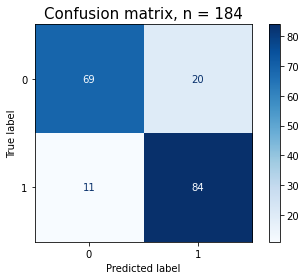

In [235]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(Ada_model,
                            tree_X_test_selected,
                            tree_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(tree_y_test)), fontsize=15)
plt.show()

#### 3.3.4 GradientBoosting

In [129]:
Grad_pipe = make_pipeline(
    GradientBoostingClassifier(random_state=2)
)

Grad_pipe.fit(tree_X_train, tree_y_train)
print('훈련 정확도: ', Grad_pipe.score(tree_X_train, tree_y_train))
print('검증 정확도: ', Grad_pipe.score(tree_X_val, tree_y_val))

훈련 정확도:  0.9522998296422487
검증 정확도:  0.9319727891156463


In [130]:
# cross-validation
Grad_model = GradientBoostingClassifier(random_state=2)

k = 5
Grad_cv_scores = cross_val_score(Grad_model,
                                tree_X_train_all,
                                tree_y_train_all,
                                cv=k,
                                scoring='accuracy'
                                )

Grad_cv_scores.mean()

0.8747181064206504

In [132]:
# GridSearchCV
param_grid = {"n_estimators":[100, 200, 300],
             "subsample":[0.5, 1],
             "max_features" : [None, 2, 3, 4],
             "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}

Grad_grid_model = GradientBoostingClassifier(random_state=42)

Grad_grid_model = GridSearchCV(Grad_grid_model,
                               param_grid=param_grid,
                               scoring = "f1",
                               verbose=2,
                               n_jobs = -1
                               )

In [133]:
Grad_grid_model.fit(tree_X_train_all, tree_y_train_all)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25,
                                           1.5],
                         'max_features': [None, 2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 1]},
             scoring='f1', verbose=2)

In [134]:
print(Grad_grid_model.best_params_)
print(Grad_grid_model.best_estimator_)

{'learning_rate': 0.2, 'max_features': 4, 'n_estimators': 100, 'subsample': 1}
GradientBoostingClassifier(learning_rate=0.2, max_features=4, random_state=42,
                           subsample=1)


In [242]:
# permutation importances
permuter = PermutationImportance(
    Grad_grid_model,                   # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(tree_X_train_all, tree_y_train_all);

In [243]:
feature_names = tree_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope          0.154496
Cholesterol       0.054768
ChestPainType     0.052316
Oldpeak           0.043869
MaxHR             0.035695
Sex               0.028610
RestingBP         0.024523
Age               0.019891
RestingECG        0.013351
FastingBS         0.009264
ExerciseAngina    0.003270
dtype: float64

In [244]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [254]:
minimum_importance = 0.01
mask = permuter.feature_importances_ > minimum_importance
features = tree_X_train_all.columns[mask]
tree_X_train_selected = tree_X_train_all[features]
tree_X_test_selected = tree_X_test[features]

In [255]:
Grad_model = GradientBoostingClassifier(learning_rate=0.2,
                                        max_features=4,
                                        random_state=42,
                                        subsample=1
                                        )

Grad_model.fit(tree_X_train_selected, tree_y_train_all);

In [256]:
Grad_y_test_pred = Grad_model.predict(tree_X_test_selected)

Grad_acc = accuracy_score(tree_y_test, Grad_y_test_pred)
Grad_auc = roc_auc_score(tree_y_test, Grad_y_test_pred)
print('accuracy_score :', Grad_acc)
print('auc_score :', Grad_auc)
print('---')
print(classification_report(tree_y_test, Grad_y_test_pred))

accuracy_score : 0.8532608695652174
auc_score : 0.8525724423418097
---
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        89
           1       0.85      0.87      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



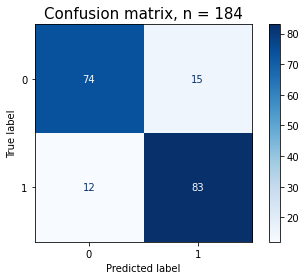

In [257]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(Grad_model,
                            tree_X_test_selected,
                            tree_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(tree_y_test)), fontsize=15)
plt.show()

#### 3.3.5 xgboost

In [136]:
xgb_pipe = make_pipeline(
    XGBClassifier(random_state=2)
)

xgb_pipe.fit(tree_X_train, tree_y_train)
print('훈련 정확도: ', xgb_pipe.score(tree_X_train, tree_y_train))
print('검증 정확도: ', xgb_pipe.score(tree_X_val, tree_y_val))

[14:28:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 정확도:  1.0
검증 정확도:  0.9523809523809523


D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [137]:
# cross-validation
xgb_model = XGBClassifier(random_state=2)

k = 5
xgb_cv_scores = cross_val_score(xgb_model,
                                tree_X_train_all,
                                tree_y_train_all,
                                cv=k,
                                scoring='accuracy'
                                )

xgb_cv_scores.mean()

D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.8569658000186375

In [140]:
# GridSearchCV
param_grid = {"n_estimators":[100, 200],
              "max_depth":[4, 5, 6], 
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1],
              "colsample_bytree":[0.5, 1]}

xgb_grid_model = XGBClassifier(random_state=42)
xgb_grid_model = GridSearchCV(xgb_grid_model,
                              param_grid=param_grid,
                              scoring = "f1",
                              verbose=2,
                              n_jobs = -1
                              )

In [141]:
xgb_grid_model.fit(tree_X_train_all, tree_y_train_all)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[14:29:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                              

In [142]:
print(xgb_grid_model.best_params_)
print(xgb_grid_model.best_estimator_)

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [258]:
# permutation importances
permuter = PermutationImportance(
    xgb_grid_model,                   # model
    scoring='accuracy',              # metric
    n_iter=5,                        # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(tree_X_train_all, tree_y_train_all);

In [259]:
feature_names = tree_X_train_all.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

ST_Slope          0.127520
Cholesterol       0.035422
Oldpeak           0.034332
ChestPainType     0.034332
Sex               0.023978
MaxHR             0.021253
RestingBP         0.016621
RestingECG        0.014986
Age               0.013624
FastingBS         0.003815
ExerciseAngina    0.002725
dtype: float64

In [260]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,                      # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names    # list 형식으로 넣어야 합니다
)

In [267]:
minimum_importance = 0.0
mask = permuter.feature_importances_ > minimum_importance
features = tree_X_train_all.columns[mask]
tree_X_train_selected = tree_X_train_all[features]
tree_X_test_selected = tree_X_test[features]

In [268]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

xgb_model.fit(tree_X_train_selected, tree_y_train_all);

[16:48:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Program Files\anaconda3\envs\project2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [269]:
xgb_y_test_pred = xgb_model.predict(tree_X_test_selected)

xgb_acc = accuracy_score(tree_y_test, xgb_y_test_pred)
xgb_auc = roc_auc_score(tree_y_test, xgb_y_test_pred)
print('accuracy_score :', xgb_acc)
print('auc_score :', xgb_auc)
print('---')
print(classification_report(tree_y_test, xgb_y_test_pred))

accuracy_score : 0.8586956521739131
auc_score : 0.8571259609698404
---
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        89
           1       0.83      0.91      0.87        95

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



D:\Program Files\anaconda3\envs\project2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



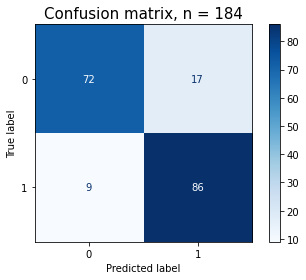

In [270]:
# confusion matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(xgb_model,
                            tree_X_test_selected,
                            tree_y_test,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title('Confusion matrix, n = {}'.format(len(tree_y_test)), fontsize=15)
plt.show()

In [271]:
compare_models = pd.DataFrame({"Model": ["Baseline", "Logistic Regression", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"],
                               "Accuracy": [base_acc, log_acc, decision_acc, RF_acc, Ada_acc, Grad_acc, xgb_acc],
                               "ROC_AUC": [base_auc, log_auc, decision_auc, RF_auc, Ada_auc, Grad_auc, xgb_auc]})

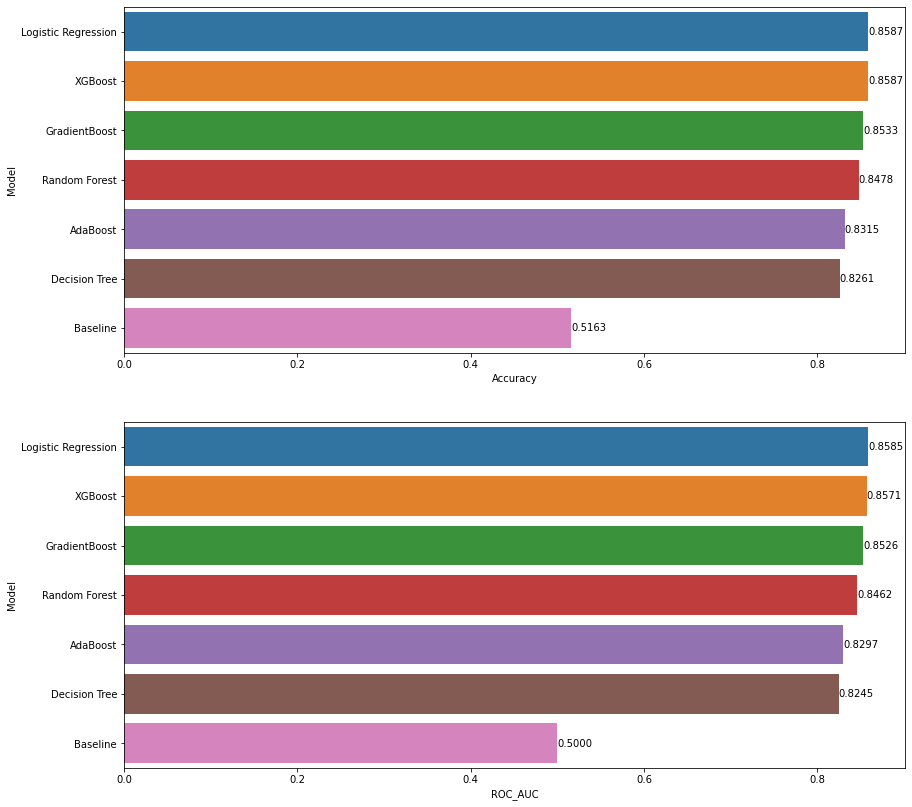

In [281]:
plt.figure(figsize=(14,14))

def labels(ax):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width,
                p.get_y() + p.get_height() / 2,
                '{:1.4f}'.format(width),
                ha = 'left',
                va = 'center'
                )

plt.subplot(211)
compare = compare_models.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare)
labels(ax)

plt.subplot(212)
compare = compare_models.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare)
labels(ax)

## 4. 모델해석

### logistic Regression

In [330]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [331]:
tree_X_test_selected.head(3)

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
440   52    1              2        128            0          0           2   
382   43    1              0        115            0          0           1   
567   71    1              0        130          221          0           2   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
440    180               0      3.0         2  
382    145               1      2.0         1  
567    115               1      0.0         1

In [332]:
tree_X_test_selected.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

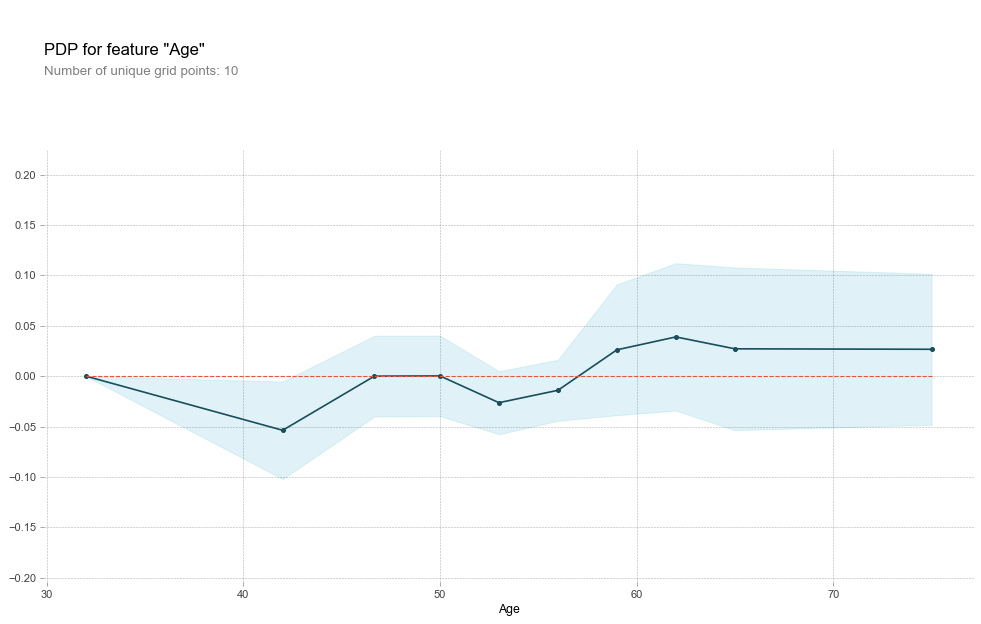

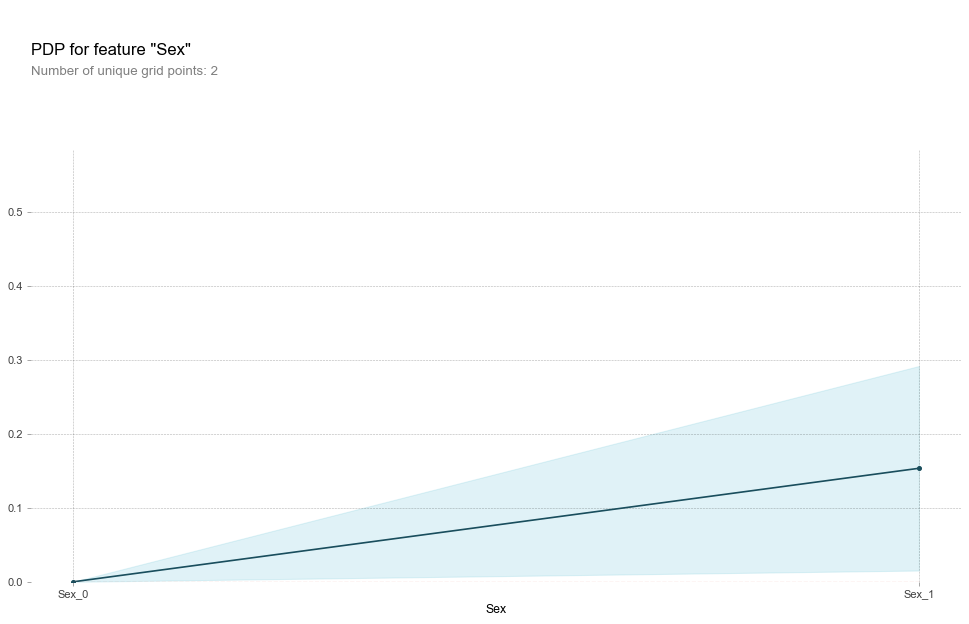

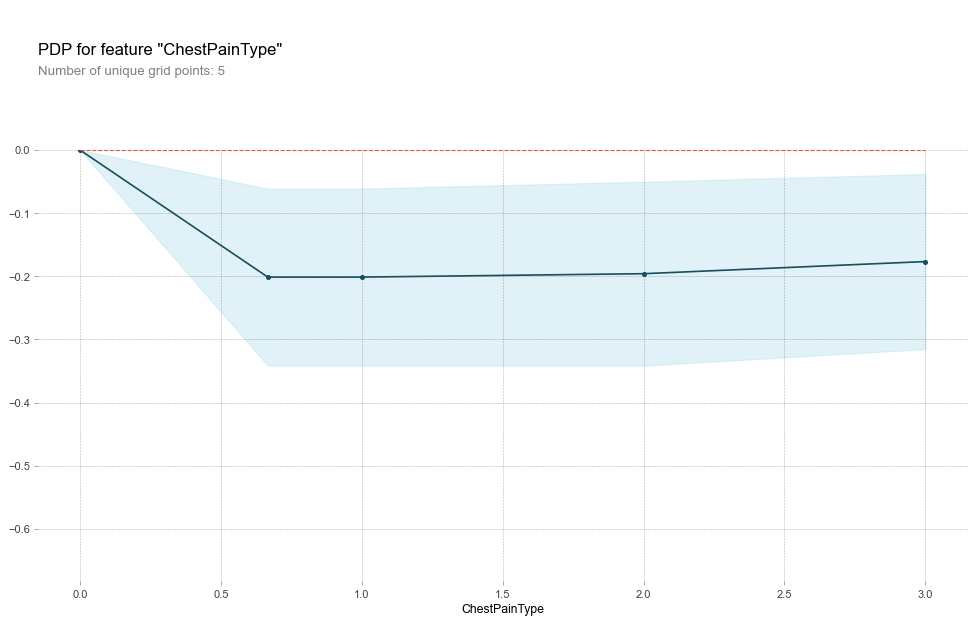

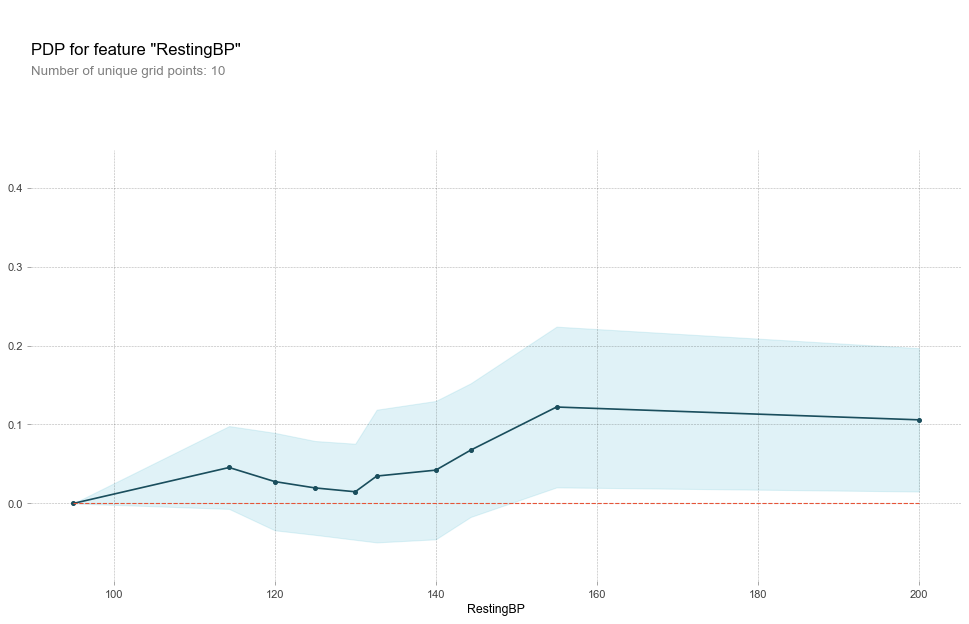

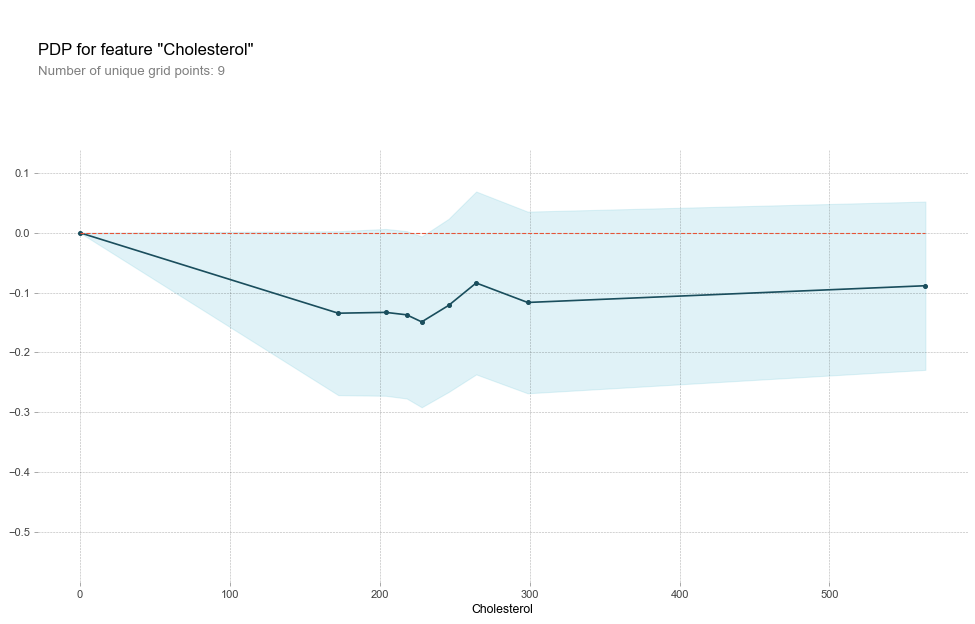

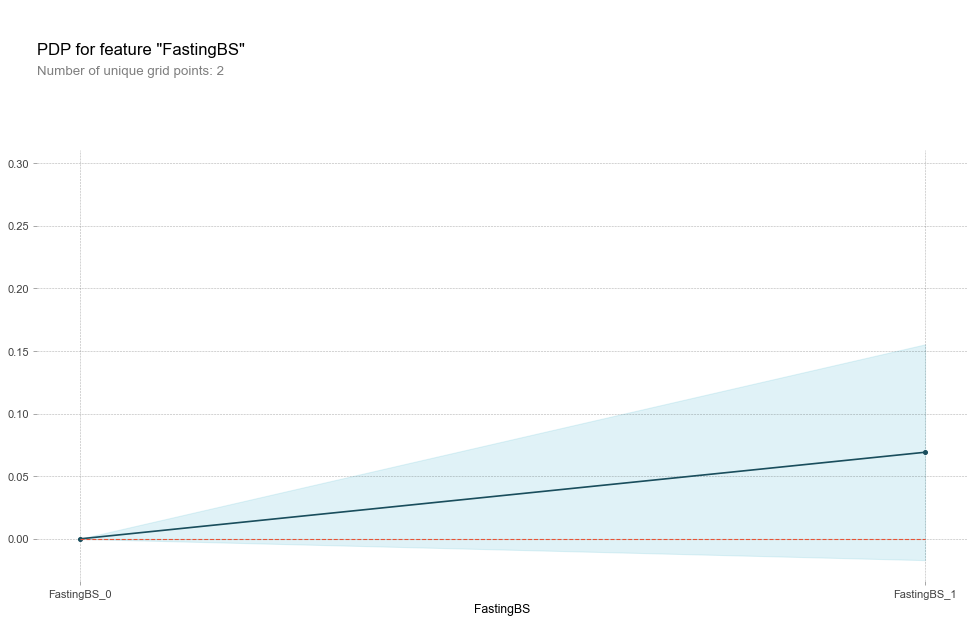

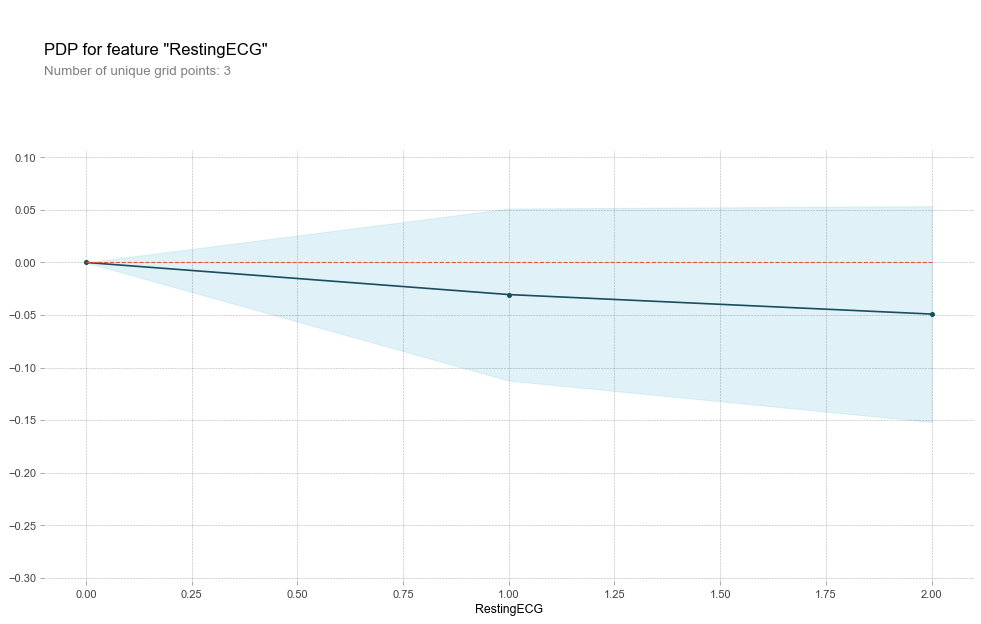

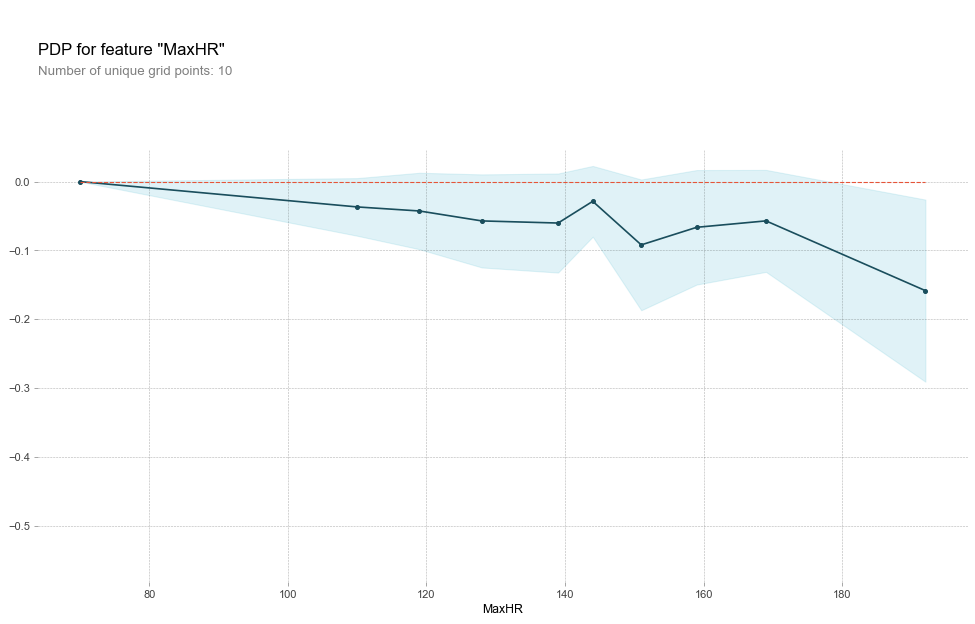

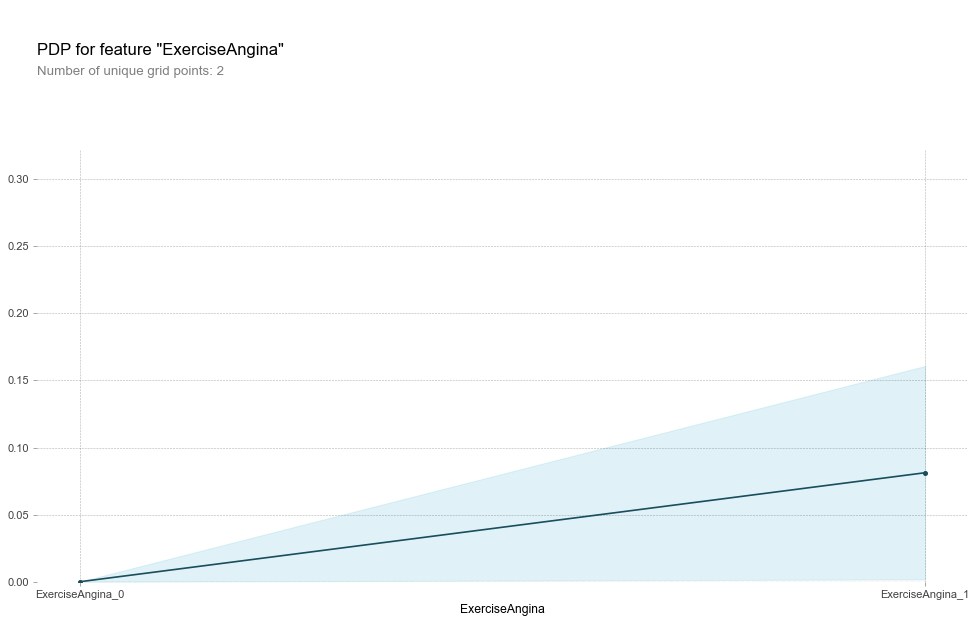

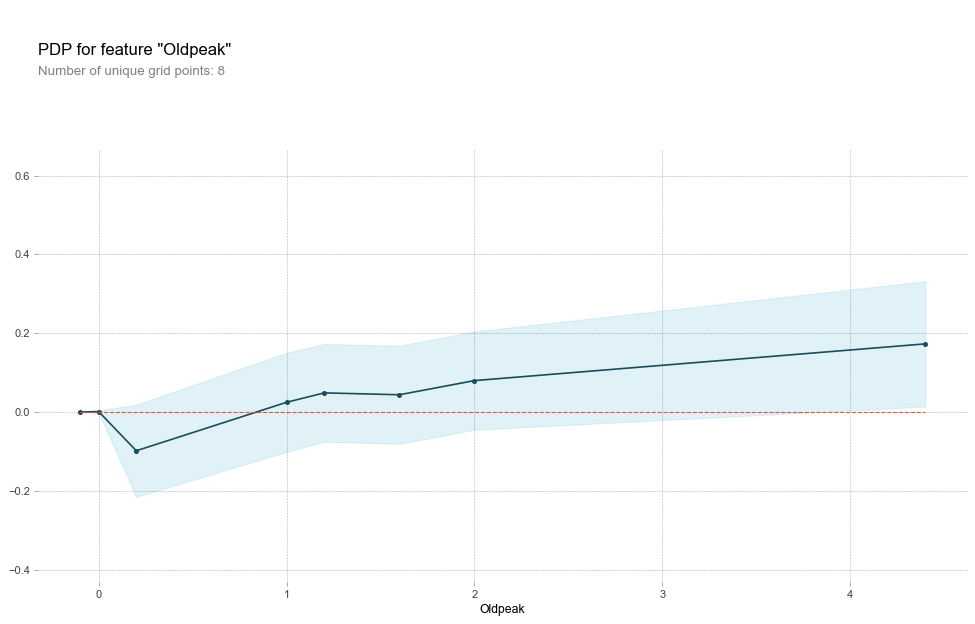

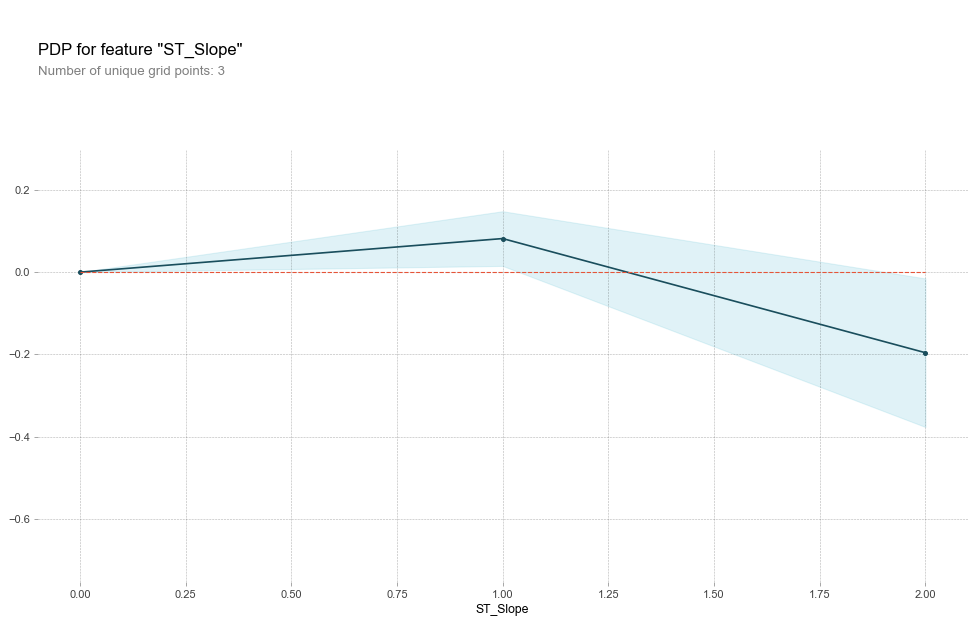

In [333]:
# dpi 수치를 조정해서 이미지 화질을 조정
plt.rcParams['figure.dpi'] = 80

# 총 4개의 feature에 대해
features = tree_X_test_selected.columns

for i in features:
    isolated = pdp_isolate(
        model = xgb_model, 
        dataset = tree_X_test_selected, 
        model_features = tree_X_test_selected.columns,
        feature = i
        )
    pdp_plot(isolated, feature_name=i);

In [334]:
features

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [335]:
interaction = pdp_interact(
    model=xgb_model, 
    dataset=tree_X_test_selected,
    model_features=tree_X_test_selected.columns, 
    features= [features[0], features[3]]
)

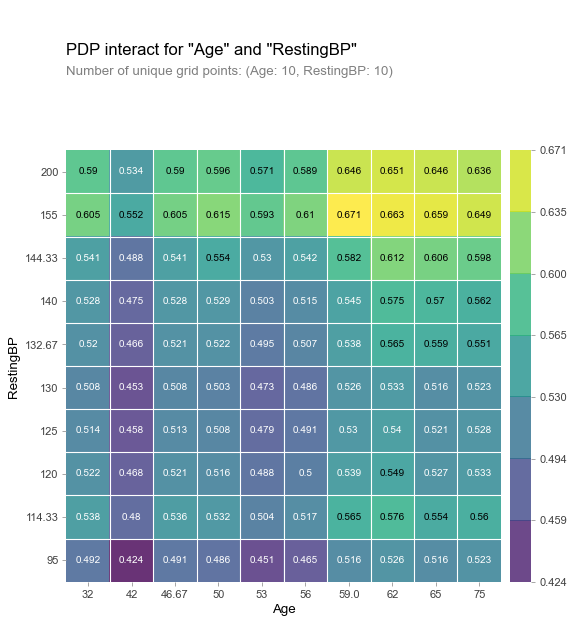

In [336]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=[features[0], features[3]]);

In [337]:
explainer = shap.TreeExplainer(xgb_model)

In [338]:
row = tree_X_test_selected.iloc[[1]]
row

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
382   43    1              0        115            0          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
382    145               1      2.0         1

In [339]:
shap_values = explainer.shap_values(row)

In [340]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [343]:
row = tree_X_test_selected.iloc[[2]]
row

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
567   71    1              0        130          221          0           2   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
567    115               1      0.0         1

In [344]:
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

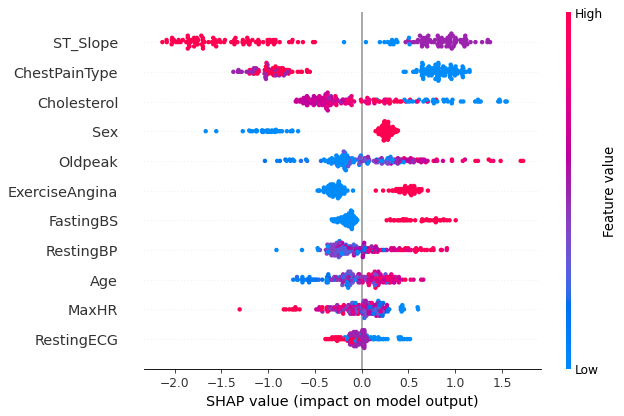

In [345]:
### Draw SHAP plots ###
shap_values = explainer.shap_values(tree_X_test_selected)
shap.summary_plot(shap_values, tree_X_test_selected)

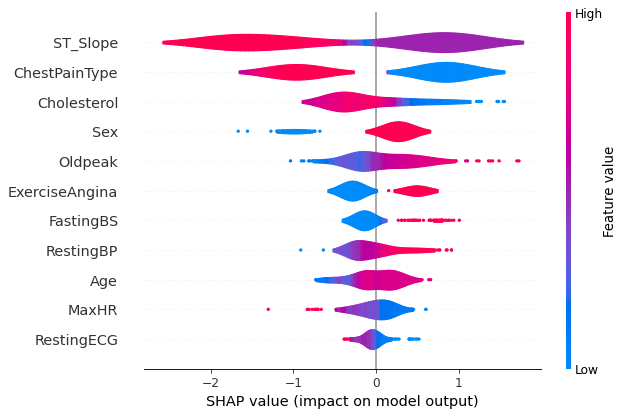

In [347]:
shap.summary_plot(shap_values, tree_X_test_selected, plot_type="violin")

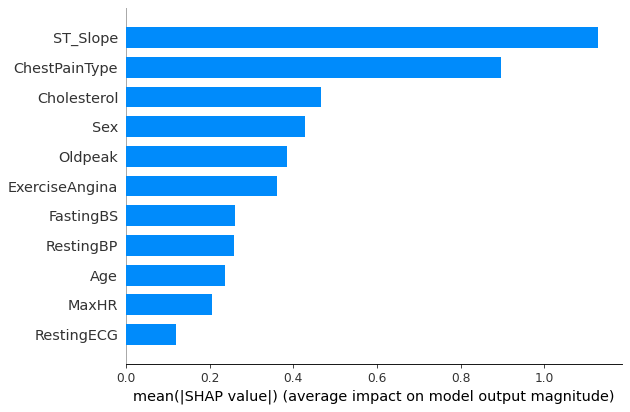

In [348]:
shap.summary_plot(shap_values, tree_X_test_selected, plot_type="bar")